<a href="https://colab.research.google.com/github/FilippoVenturini8/ProgettoDataIntensive/blob/main/Progetto_Data_Intensive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Previsione della temperatura del rotore di un motore a magneti permanenti

***Programmazione di Applicazioni Data Intensive***

*2021/2022*

*Filippo Venturini*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##Import del dataset

Le seguenti istruzioni provvedono a importare il dataset utilizzando le credenziali di kaggle contenute nel file `kaggle.json`. Procedere quindi quando richiesto dall'istruzione `files.upload()` a selezionare il file `kaggle.json` precedentemente scaricato.
Se nel notebook è già presente il file csv del dataset, passare alla fase di descrizione del problema.

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"filippoventurini","key":"78dd9bc94b21a574da3b556a75a91f4e"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d wkirgsn/electric-motor-temperature

 85% 99.0M/117M [00:01<00:00, 71.2MB/s]
100% 117M/117M [00:02<00:00, 59.4MB/s] 


In [ ]:
!unzip "/content/electric-motor-temperature.zip" -d "/content/"

Archive:  /content/electric-motor-temperature.zip
  inflating: /content/measures_v2.csv  


##Descrizione del problema

Il dataset contiene dati rilevati da particolari sensori che monitorano la temperatura di un motore elettrico. Il motore presenta due componenti principali lo statore e il rotore, che sono rispettivamente la parte statica e la parte mobile di esso. 
L'obbiettivo è svolgere uno studio che permetta di predire tramite l'uso di modelli di regressione la temperatura del rotore. La previsione della suddetta temperatura aiuta l'industria automobilistica a produrre motori con meno materiale e consente di utilizzare il motore al massimo delle sue capacità.

In [ ]:
data = pd.read_csv("measures_v2.csv")

##Comprensione dei dati

In [ ]:
data.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


Di seguito si procede ad illustrare l'elenco delle **feature** presenti nel dataset



*   `u_q`: voltaggio del componente q in coordinate dq (in Volt)
*   `coolant`: temperatura del liquido di raffreddamento (in °C)
*   `stator_winding`: temperatura della bobina dello statore (in °C)
*   `u_d`: voltaggio del componente q in coordinate dq (in Volt)
*   `stator_tooth`: temperatura del dente dello statore (in °C)
*   `motor_speed`: velocità del motore (in rpm)
*   `i_d`: misura corrente del componente d in coordinate dq
*   `i_q`: misura corrente del componente q in coordinate dq
*   `pm`: temperatura del rotore del motore a magneti permanenti (in °C)
*   `stator_yoke`: temperatura del giogo dello statore (in °C)
*   `ambient`: temperatura dell'ambiente (in °C)
*   `torque`: dimensione coppia del motore (in Nm)
*   `profile_id`: identificatore della sessione di misurazione







La variabile target è `pm`, è una variabile continua che indica la temperatura del rotore del motore a magneti permanenti.
Tutte le feauture prese in considerazione sono delle variabili continue, alcune indicano la temperatura dei vari componenti del motore, altre il voltaggio e altre ancora la dimensione.

##Analisi Esplorativa

Procediamo ora a esaminare le specifiche informazioni sulle feature, formattando l'output in modo da rimuovere la notazione scientifica e rendere più chiari i valori visualizzati.

In [ ]:
data.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1330816.00000,1330816.00000,1330816.00000,1330816.00000,1330816.00000,1330816.00000,1330816.00000,1330816.00000,1330816.00000,1330816.00000,1330816.00000,1330816.00000,1330816.00000
mean,54.27900,36.22999,66.34275,-25.13381,56.87858,2202.08073,-68.71681,37.41278,58.50678,48.18796,24.56526,31.10603,40.79306
std,44.17323,21.78615,28.67206,63.09197,22.95223,1859.66335,64.93323,92.18188,19.00150,19.99100,1.92952,77.13575,25.04549
min,-25.29093,10.62375,18.58582,-131.53041,18.13398,-275.54914,-278.00363,-293.42679,20.85696,18.07669,8.78348,-246.46666,2.00000
25%,12.06992,18.69814,42.78796,-78.69090,38.41601,317.11066,-115.40606,1.09586,43.15158,31.99033,23.18480,-0.13743,17.00000
50%,48.93818,26.90014,65.11013,-7.42975,56.03635,1999.97668,-51.09376,15.77401,60.26629,45.62551,24.79733,10.86035,43.00000
75%,90.03439,49.85749,88.14114,1.47027,75.58668,3760.63906,-2.97969,100.61215,72.00837,61.46083,26.21702,91.59718,65.00000
max,133.03699,101.59851,141.36288,131.46979,111.94642,6000.01514,0.05190,301.70786,113.60663,101.14796,30.71420,261.00571,81.00000


Rilevando le informazioni principali sul dataset, ricaviamo che il numero di istanze è `1.330.816` e per ogni feature possiamo osservare la **media**, il **minimo**, il **massimo**, la **deviazione standard** e infine i **percentili**.

Se consideriamo ad esempio la variabile target `pm`, che indica la temperatura del motore a magneti permanenti, essa ha un minimo di circa 21°C e un massimo di circa 114°C, con una media di 59°C.



###Rimozione valori nulli e identificatori

Tra le feature sopra elencate vi è un **identificatore** della misurazione `profile_id` che si riferisce all'id univoco della misurazione, può di conseguenza essere rimosso in quanto non rilevante per il nostro caso di studio.

In [ ]:
data = data.drop("profile_id",axis=1)

Procedendo è necessario verificare se sono presenti valori **nulli** all'interno del dataset.

In [ ]:
data.isna().sum()

u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
dtype: int64

All'interno del dataset non sono presenti valori nulli, non è quindi necessario gestirli.

In [ ]:
data.nunique().sort_values()

motor_speed        777565
i_q               1024944
i_d               1047491
coolant           1110491
torque            1157267
ambient           1193868
stator_yoke       1228430
stator_tooth      1229028
stator_winding    1262752
u_q               1271775
u_d               1295778
pm                1316978
dtype: int64

Esaminando il **numero di valori distinti** delle feature notiamo (come ci aspettavamo, essendo tutte variabili continue) un numero di valori distinti molto elevato e abbastanza uniforme.

##Correlazione tra le feature

Ora è necessario esaminare alcune coppie di feature per verificare che ci sia effettivamente una **correlazione**, quindi una dipendenza, tra di esse. Questo permette anche di analizzare meglio il dominio del dataset, che in questo caso presenta feature molto tecniche e non di immediata comprensione per chi non conosce l'argomento.

Dal momento che il dataset presenta un'elevata quantità di istanze, è necessario prelevare un **campione casuale** dei dati per rendere più leggibili i grafici a dispersione.

In [ ]:
sample = data.sample(n=1000, random_state=1)

Di seguito verranno illustrati vari grafici a dispersione che mostrano la correlazione presente tra alcune coppie di feature, in particolare anche riguardanti la variabile target da predire `pm`.

Text(0.5, 0, 'motor_speed')

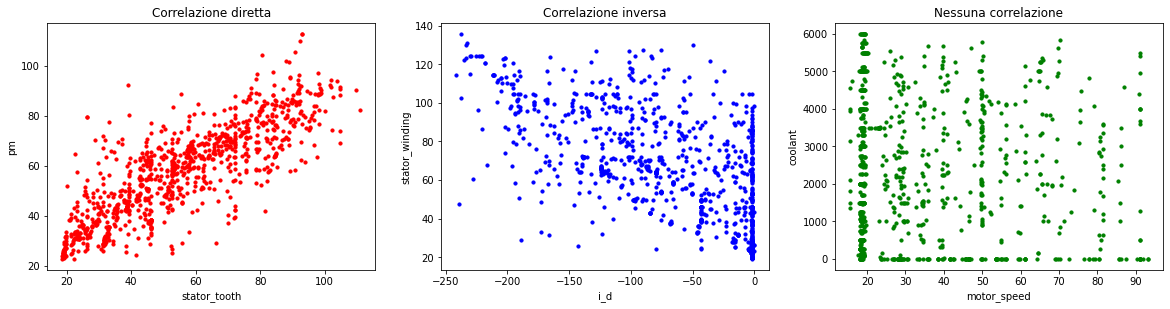

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.title('Correlazione diretta')
plt.scatter(sample['stator_tooth'],sample['pm'],s=10,c='red')
plt.ylabel('pm')
plt.xlabel('stator_tooth')

plt.subplot(2, 3, 2)
plt.title('Correlazione inversa')
plt.scatter(sample['i_d'],sample['stator_winding'],s=10,c='blue')
plt.ylabel('stator_winding')
plt.xlabel('i_d')

plt.subplot(2, 3, 3)
plt.title('Nessuna correlazione')
plt.scatter(sample['coolant'],sample['motor_speed'],s=10,c='green')
plt.ylabel('coolant')
plt.xlabel('motor_speed')

Con i grafici a dispersione risulta chiaro che in questo caso di studio sono presenti tutti e tre i tipi di correlazione tra feature:

1.   **Correlazione diretta**: la temperatura del motore è direttamente proporzionale alla dimensione del dente dello statore. 

2.   **Correlazione inversa**: meno corrente arriva al componente d, più aumenta la temperatura della bobina dello statore.

3.   **Assenza di correlazione**: esaminando il grafico si nota che la velocità del motore non è correlata con la temperatura del liquido di raffreddamento.


###Distribuzione delle variabili

Di seguito vengono mostrati degli **istogrammi** che chiarificano la distribuzione di alcune feature (già identificate come variabili continue) nel range di valori [min, max] già esaminato in precedenza.

Text(0.5, 0, 'ambient')

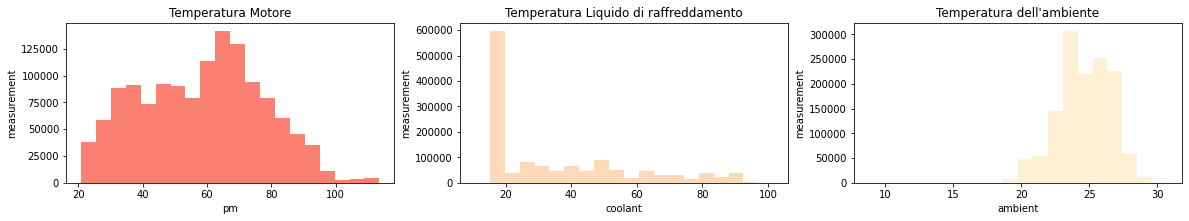

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(3, 3, 1)
plt.title('Temperatura Motore')
plt.hist(data['pm'], bins=20, color = 'salmon')
plt.ylabel('measurement')
plt.xlabel('pm')

plt.subplot(3, 3, 2)
plt.title('Temperatura Liquido di raffreddamento')
plt.hist(data['coolant'], bins=20, color = 'peachpuff')
plt.ylabel('measurement')
plt.xlabel('coolant')

plt.subplot(3, 3, 3)
plt.title('Temperatura dell\'ambiente')
plt.hist(data['ambient'], bins=20, color = 'papayawhip')
plt.ylabel('measurement')
plt.xlabel('ambient')

Text(0.5, 0, 'stator_yoke')

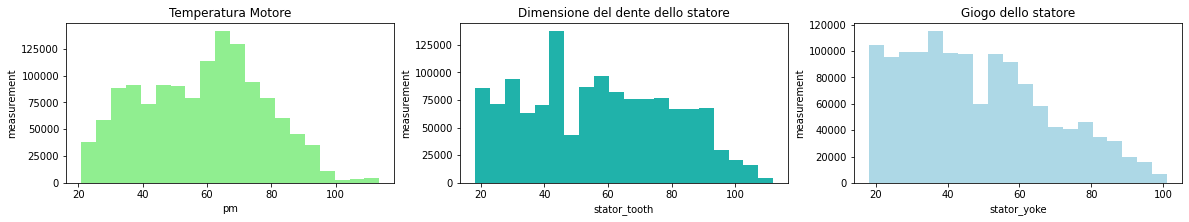

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(3, 3, 1)
plt.title('Temperatura Motore')
plt.hist(data['pm'], bins=20, color = 'lightgreen')
plt.ylabel('measurement')
plt.xlabel('pm')

plt.subplot(3, 3, 2)
plt.title('Dimensione del dente dello statore')
plt.hist(data['stator_tooth'], bins=20, color = 'lightseagreen')
plt.ylabel('measurement')
plt.xlabel('stator_tooth')

plt.subplot(3, 3, 3)
plt.title('Giogo dello statore')
plt.hist(data['stator_yoke'], bins=20, color = 'lightblue')
plt.ylabel('measurement')
plt.xlabel('stator_yoke')

Text(0.5, 0, 'motor_speed')

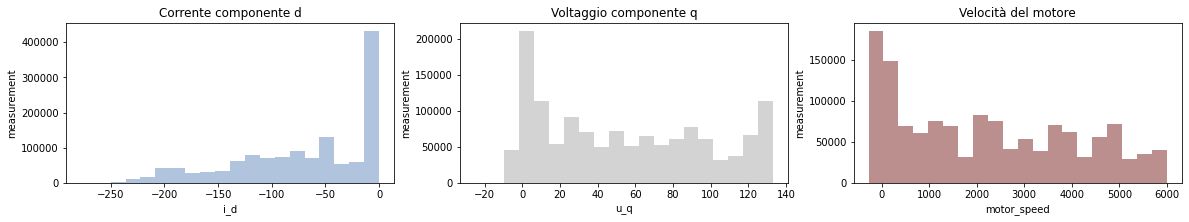

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(3, 3, 1)
plt.title('Corrente componente d')
plt.hist(data['i_d'], bins=20, color = 'lightsteelblue')
plt.ylabel('measurement')
plt.xlabel('i_d')

plt.subplot(3, 3, 2)
plt.title('Voltaggio componente q')
plt.hist(data['u_q'], bins=20, color = 'lightgray')
plt.ylabel('measurement')
plt.xlabel('u_q')

plt.subplot(3, 3, 3)
plt.title('Velocità del motore')
plt.hist(data['motor_speed'], bins=20, color = 'rosybrown')
plt.ylabel('measurement')
plt.xlabel('motor_speed')

###Controllo outliers

Di seguito si procede a visualizzare le distribuzioni delle variabili tramite **boxplot** per verificare la presenza di eventuali **outlier**.

{'boxes': [<matplotlib.lines.Line2D at 0x7f96d823c490>],
 'caps': [<matplotlib.lines.Line2D at 0x7f96d82444d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f96d81cc510>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f96d8244f90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f96d823ca10>,
  <matplotlib.lines.Line2D at 0x7f96d823cf50>]}

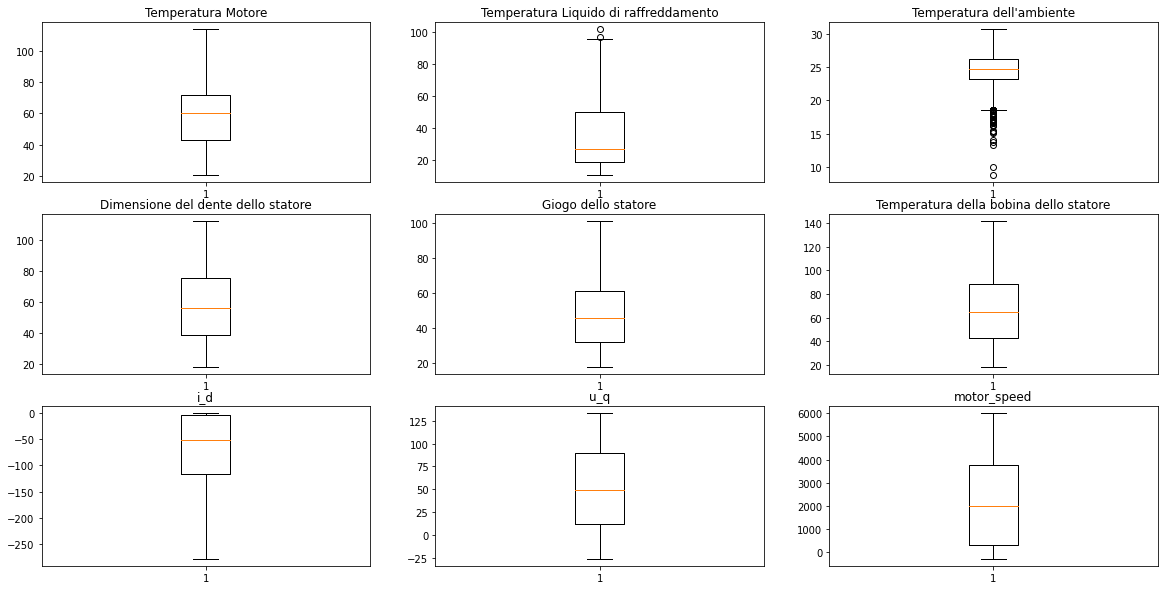

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(3, 3, 1)
plt.title('Temperatura Motore')
plt.boxplot(data['pm'])

plt.subplot(3, 3, 2)
plt.title('Temperatura Liquido di raffreddamento')
plt.boxplot(data['coolant'])

plt.subplot(3, 3, 3)
plt.title('Temperatura dell\'ambiente')
plt.boxplot(data['ambient'])

plt.subplot(3, 3, 4)
plt.title('Dimensione del dente dello statore')
plt.boxplot(data['stator_tooth'])

plt.subplot(3, 3, 5)
plt.title('Giogo dello statore')
plt.boxplot(data['stator_yoke'])

plt.subplot(3, 3, 6)
plt.title('Temperatura della bobina dello statore')
plt.boxplot(data['stator_winding'])

plt.subplot(3, 3, 7)
plt.title('i_d')
plt.boxplot(data['i_d'])

plt.subplot(3, 3, 8)
plt.title('u_q')
plt.boxplot(data['u_q'])

plt.subplot(3, 3, 9)
plt.title('motor_speed')
plt.boxplot(data['motor_speed'])

Visualizzando le distribuzioni delle feature tramite `boxplot` notiamo che sono presenti alcuni **outliers** nella feature `ambient` che riguarda la temperatura dell'ambiente. Notiamo però che sono distribuiti abbastanza uniformemente e si trovano in corrispondenza di valori accettabili di temperatura.


###Matrice di correlazione

Procediamo di seguito a visualizzare la **matrice di correlazione** tra tutte le coppie di feature, ricavandone una visione d'insieme.

In [ ]:
def plot_correlation(dataset):
    cmap = sns.diverging_palette(30, 240, as_cmap=True)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(dataset, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(dataset, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True, square=True, linewidths=.5, cbar_kws={"shrink": .5});

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


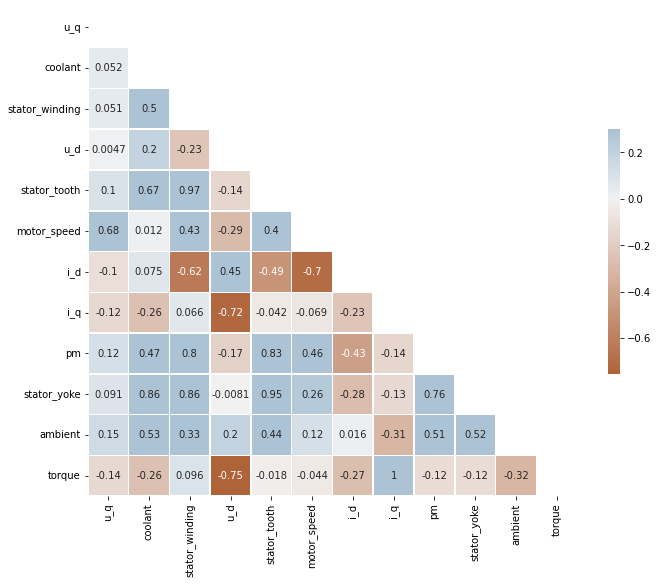

In [ ]:
plot_correlation(data.corr())

Si noti come in generale ci sono più feature che riguardano lo stesso componente (es. lo statore) e che quindi hanno una correlazione forte tra di loro.

*   `stator_yoke` e `stator_winding` : la temperatura della bobina dello statore e del suo giogo sono fortemente correlate, facendo parte dello stesso componente.

*   `stator_yoke` e `stator_tooth`: allo stesso modo, la temperatura del dente dello statore influenza fortemente temperatura del suo giogo.

*   `ambient` e `pm`: c'è una discreta correlazione tra la temperatura dell'ambiente di sperimentazione e la temperatura del motore a magneti permanenti.

*   `pm`, `stator_winding`, `stator_yoke` e `stator_tooth`: la temperatura del rotore del motore a magneti permanenti (ovvero la variabile target) è fortemente influenzata da tutte le feature che riguardano lo statore. Questo è riconducibile al fatto che lo statore e il rotore sono le due componenti fondamentali di un motore elettrico e lavorano a stretto contatto.


##Normalizzazione e standardizzazione

In questa fase è necessario iniziare a valutare il comportamento di alcuni semplici modelli di regressione sul dataset, per poter determinare l'efficacia della **standardizzazione** delle feature e dell'individuazione di quelle meno rilevanti. Verrà inoltre valutato se la rimozione di alcune feature possa rendere più performanti i modelli utilizzati.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Di seguito sono definite due funzioni utili rispettivamente per determinare l'errore relativo e stampare le valutazioni sul modello passato in input.

In [ ]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

###Standardizzazione

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression,Lasso, Ridge
from sklearn.kernel_ridge import KernelRidge

Procedendo è necessario effettuare una prima semplice divisione del dataset in training set e validation set, per poter addestrare un semplice modello di regressione lineare. 

Si procede inoltre a definire come X l'insieme delle feature note mentre come y la variabile target da predire `pm`.

In [ ]:
y = data["pm"]
X = data.drop(columns="pm")

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

In [ ]:
simpleModel = Pipeline([
    ("lr", LinearRegression())
])
simpleModel.fit(X_train, y_train)
print_eval(X_val, y_val, simpleModel)

   Mean squared error: 52.506
       Relative error: 10.48681%
R-squared coefficient: 0.85477


Addestrando un semplice modello di regressione lineare senza normalizzazione o feature non lineari, otteniamo comunque un coefficiente **R-squared** abbastanza elevato. Notiamo però che l'errore quadratico medio è oltre il 50%.

In [ ]:
pd.Series(simpleModel.named_steps["lr"].coef_, X.columns)

u_q              -0.131387
coolant          -0.188153
stator_winding   -1.601563
u_d              -0.019191
stator_tooth      3.967936
motor_speed       0.002932
i_d               0.042736
i_q              -0.010221
stator_yoke      -1.567858
ambient           1.764148
torque            0.005360
dtype: float64

Analizzando i coefficienti determinati dal modello notiamo come la dimensione del dente dello statore sia la feature che più influenza la variabile target, viene inoltre confermato ciò che era stato dedotto in precedenza, le feature riguardanti lo statore sono quelle che hanno il coefficiente di peso maggiore essendo esso a stretto contatto con il rotore.

Ora procediamo ad aggiungere alla PipeLine la funzione `StandardScaler()` continuando comunque ad utilizzare un modello di regressione lineare semplice, per **standardizzare** e **scalare** le feature.

In [ ]:
simpleModelScaled = Pipeline([
    ("scale", StandardScaler()),
    ("lr", LinearRegression())
])
simpleModelScaled.fit(X_train, y_train)
print_eval(X_val, y_val, simpleModelScaled)

   Mean squared error: 52.506
       Relative error: 10.48681%
R-squared coefficient: 0.85477


In [ ]:
pd.Series(simpleModelScaled.named_steps["lr"].coef_, X.columns)

u_q               -5.802005
coolant           -4.098601
stator_winding   -45.920585
u_d               -1.211314
stator_tooth      91.071627
motor_speed        5.452752
i_d                2.775532
i_q               -0.942190
stator_yoke      -31.346429
ambient            3.404513
torque             0.413476
dtype: float64

###Individuazione delle feature meno rilevanti

Una volta standardizzate le feature è richiesto di verificare, tramite la regressione **Lasso**, la presenza di **multicollinearità** tra di esse e controllare se la loro rimozione incide sull'errore del modello e in quale misura.

Applichiamo la regressione Lasso con un **iperparametro** arbitrario ma accettabile, in quanto ci occuperemo in seguito di determinarne il valore ottimale tramite **Grid Search**.

In [ ]:
modelLasso = Pipeline([
    ("scale", StandardScaler()),
    ("lasso", Lasso(alpha=0.2))
])
modelLasso.fit(X_train, y_train);
print_eval(X_val, y_val, modelLasso)


   Mean squared error: 65.68
       Relative error: 11.92933%
R-squared coefficient: 0.81833


In [ ]:
pd.Series(modelLasso.named_steps["lasso"].coef_, X.columns)

u_q               -3.953253
coolant           -4.683511
stator_winding    -0.000000
u_d               -2.974777
stator_tooth      16.612941
motor_speed        6.574117
i_d                4.824844
i_q               -0.000000
stator_yoke        0.000000
ambient            4.116509
torque            -2.808296
dtype: float64

Notiamo che come previsto c'è una diminuzione dell'accuratezza misurata da **R-squared**, dovuta alla rimozione di alcune feature.
Consideriamo anche il fatto che le feature che sono state annullate da Lasso (`stator_winding`, `stator_yoke`, `i_q`) avevano una forte dipendenza tra loro essendo feature correlate allo stesso componente, lo statore, del quale è rimasta la dimensione del dente (`stator_tooth`).

Addestriamo ora un modello più complesso, utilizzando feature non lineari, per cercare di abbassare l'**MSE**, permettendo al modello di approssimare meglio i dati. Anche qui scegliamo l'iperparametro del grado del polinomio in modo arbitrario, ci occuperemo in seguito di selezionarne il valore ottimale, per ora è importante capire se con l'utilizzo di feature non lineari le prestazioni migliorano.

In [ ]:
model2 = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("std",  StandardScaler()),
    ("lr", LinearRegression())
])
model2.fit(X_train, y_train)
print_eval(X_val, y_val, model2)

   Mean squared error: 22.518
       Relative error: 6.01983%
R-squared coefficient: 0.93772


Utilizzando le feature polinomiali l'**MSE** viene ridotto come ci si auspicava, a discapito però dei tempi di esecuzione, avendo il dataset oltre 1.000.000 di istanze i tempi risultano penalizzanti.

Proviamo ora ad abbassare i tempi di esecuzione rimuovendo le variabili azzerate da Lasso e verifichiamo quanta accuratezza sulle predizioni viene persa.

In [ ]:
X_train, X_val, y_train, y_val = X_train.drop(columns=["stator_winding","stator_yoke","i_q"]), X_val.drop(columns=["stator_winding","stator_yoke","i_q"]), y_train.drop(columns=["stator_winding","stator_yoke","i_q"]),y_val.drop(columns=["stator_winding","stator_yoke","i_q"])

In [ ]:
simpleModelScaled = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scale", StandardScaler()),
    ("lr", LinearRegression())
])
simpleModelScaled.fit(X_train, y_train)
print_eval(X_val, y_val, simpleModelScaled)

   Mean squared error: 30.244
       Relative error: 7.06565%
R-squared coefficient: 0.91634


Il coefficiente **R-squared** è diminuito di un valore trascurabile (circa 0.02) ma abbiamo **dimezzato** il tempo di addestramento del modello.

Di conseguenza possiamo rimuovere le 3 feature collineari individuate da Lasso e procedere ad addestrare modelli più performanti, determinandone gli iperparametri tramite **Grid-Search**.

In [ ]:
data = data.drop(columns=["stator_winding","stator_yoke","i_q"])

##Addestramento modelli di regressione

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In questa sezione ci occuperemo di addestrare vari modelli di regressione e di valutare quale tra quelli utilizzati risulta più accurato.

Ora utilizzando la **Grid Search** e la **Nested K-Fold** validation determiniamo i migliori iperparametri per i modelli.

Come precedentemente accennato, il dataset presenta un numero veramente elevato di istanze, perciò è necessario prelevarne un campione per effetturare le varie Grid Search in tempi ragionevoli. Una volta stabiliti gli iperparametri ottimali, il modello migliore verrà addestrato e testato sull'intero dataset.

In [ ]:
dataSample = data.sample(n=10000, random_state=1)
y = dataSample["pm"]
X = dataSample.drop(columns="pm")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

In [ ]:
kf = KFold(5, shuffle=True, random_state=42)

Viene prelevato un campione casuale composto da 10000 istanze, vengono riassegnate le variabili corrispondenti al training e al validation set e viene infine creato un oggetto **K-fold**, che verrà utilizzato dalle Grid-Search, composto da 5 fold.

Notiamo che nella fase precedente, l'aggiunta di feature non lineari (nello specifico l'utilizzo di un polinomio di terzo grado) ha portato significative variazioni sui parametri di valutazione dei modelli:

**Regressione Lineare:**
*   Mean squared error: 65.68
*   Relative error: 11.92933%
*   R-squared coefficient: 0.81833


**Regressione non Lineare:**
*   Mean squared error: 22.518
*   Relative error: 6.01983%
*   R-squared coefficient:  0.93772

Notiamo quindi un abbassamento dell'**MSE** di oltre 40 unità, un abbassamento dell'**errore relativo** circa del 6% e un aumento del coefficiente **R-squared** di oltre 0.12.

Possiamo quindi non considerare modelli di regressione lineare e occuparci direttamente di modelli che contengono **feature polinomiali**. Ricordiamoci inoltre che sono state rimosse le tre feature individuate da Lasso, di conseguenza i coefficienti di errore visualizzati potrebbero essere leggermente inferiori a quelli riportati sopra, a differenza dei tempi di esecuzione che saranno più performanti.

###Regressione Polinomiale, Ridge e Kernel Ridge

In [ ]:
polyModel = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
polyGrid = {
    "poly__degree": [2, 3, 4],
}
gs = GridSearchCV(polyModel, polyGrid, cv=kf)
gs.fit(X_train, y_train)
print('Best param: '+str(gs.best_params_))
print_eval(X_val, y_val, gs)

Best param: {'poly__degree': 3}
   Mean squared error: 32.118
       Relative error: 7.16393%
R-squared coefficient: 0.91326


Effettuando una prima Grid-Search su un modello non lineare viene determinato come iperparametro ottimale un polinomio di grado 3, vengono inoltre mostrati i vari coefficienti d'errore.

Proviamo ora ad applicare al modello la regolarizzazione con **norma L2**, applicando la regressione **Ridge**, in modo da ridurre i coefficienti del polinomio e verificare se in questo caso di studio porta dei vantaggi.

In [ ]:
modelRidge = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", Ridge())
])
ridgeGrid = {
    "poly__degree": [2, 3],
    "regr__alpha":  [0.001, 0.01, 0.1]
}
gs = GridSearchCV(modelRidge, ridgeGrid, cv=kf)
gs.fit(X_train, y_train)
print('Best param: '+str(gs.best_params_))
print_eval(X_val, y_val, gs)

Best param: {'poly__degree': 3, 'regr__alpha': 0.01}
   Mean squared error: 32.599
       Relative error: 7.23109%
R-squared coefficient: 0.91197


La Grid-Search ha restituito come peso ottimale della regolarizzazione 0.01 e come grado del polinomio sempre 3. Notiamo però che tutti e tre i coefficienti d'errore sono **leggermente peggiori** di quelli ottenuti senza regolarizzazione.

A questo punto è possibile provare ad effettuare un addestramento su un modello **Kernel Ridge** per verificarne l'accuratezza.

In [ ]:
modelKernel = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(kernel="poly"))
])
kernelGrid = {
    "regr__degree": range(3, 5),
    "regr__alpha": [0.01, 1],
}

gs = GridSearchCV(modelKernel, kernelGrid, cv=kf)
gs.fit(X_train, y_train)
print('Best param: '+str(gs.best_params_))
print_eval(X_val, y_val, gs)

Best param: {'regr__alpha': 0.01, 'regr__degree': 4}
   Mean squared error: 26.374
       Relative error: 6.36214%
R-squared coefficient: 0.92878


Notiamo che la Grid-Search stabilisce come migliori iperparametri un polinomio di grado 4 e un peso della regolarizzazione pari a 0.01.

Questo modello rispetto ai tre precedentemente esaminati è sicuramente quello che meglio si adatta al problema, notiamo però che i **tempi** di esecuzione sono abbastanza **lunghi** nonostante venga addestrato su un campione del dataset.

Questo potrebbe essere un problema, considerando che il caso di studio presenta un **numero molto elevato di istanze**.

##Alberi di regressione

A questo punto è possibile provare ad utilizzare gli alberi di regressione visti durante il corso e comparare le loro prestazioni con i modelli addestrati nelle fasi precedenti.

###LightGBM

In [ ]:
from lightgbm import LGBMRegressor

Il primo albero su cui andiamo ad effettuare l'addestramento è il **Light Gradient Boosting Machine** dal quale ci aspettiamo una discreta velocità di addestramento.

In [ ]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [ ]:
print_eval(X_val, y_val, lgbm)

   Mean squared error: 21.863
       Relative error: 5.69853%
R-squared coefficient: 0.94096


Come previsto l'addestramento del modello è avvenuto molto velocemente e i coefficienti d'errore risultano **migliori** persino di **Kernel Ridge**.

###XGBoost

In [ ]:
from xgboost import XGBRegressor

Il secondo albero di regressione che esaminiamo è **XGBoost** che implementa l'algoritmo **eXtreme Gradient Boosting**.

In [ ]:
xgbm = XGBRegressor(objective='reg:squarederror', reg_alpha=0.0, reg_lambda=1.0, n_estimators=200, verbose_eval=True)
xgbm.fit(X_train, y_train)

XGBRegressor(n_estimators=200, objective='reg:squarederror', reg_alpha=0.0,
             reg_lambda=1.0, verbose_eval=True)

In [ ]:
print_eval(X_val, y_val, xgbm)

   Mean squared error: 31.267
       Relative error: 7.32453%
R-squared coefficient: 0.91556


Il tempo di addestramento di questo modello è leggermente maggiore di LightGBM e notiamo che i coefficienti d'errore sono peggiori, perciò XGBoost riesce a modellare il problema in maniera molto buona (R-squared: 0.91) ma inferiore a LightGBM.

###CatBoost

Come ultimo albero di regressione esaminiamo **CatBoost** che implementa il **Category Gradient Boosting**.

In [ ]:
%pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


Per utilizzarlo è necessario installare e importare la libreria `catboost`

In [ ]:
import catboost
from catboost import CatBoostRegressor

In [ ]:
catbm = CatBoostRegressor(n_estimators=1000)
catbm.fit(X_train, y_train)

Learning rate set to 0.055252
0:	learn: 18.0995381	total: 52ms	remaining: 51.9s
1:	learn: 17.4164768	total: 55.2ms	remaining: 27.5s
2:	learn: 16.7422885	total: 58.4ms	remaining: 19.4s
3:	learn: 16.1226368	total: 61.6ms	remaining: 15.3s
4:	learn: 15.5499491	total: 64.7ms	remaining: 12.9s
5:	learn: 15.0040929	total: 67.7ms	remaining: 11.2s
6:	learn: 14.5083114	total: 72.8ms	remaining: 10.3s
7:	learn: 14.0362760	total: 79.1ms	remaining: 9.81s
8:	learn: 13.5913454	total: 82.4ms	remaining: 9.08s
9:	learn: 13.1792210	total: 85.8ms	remaining: 8.5s
10:	learn: 12.7882436	total: 89.1ms	remaining: 8.01s
11:	learn: 12.4380730	total: 92.3ms	remaining: 7.6s
12:	learn: 12.0944725	total: 95.5ms	remaining: 7.25s
13:	learn: 11.7783198	total: 98.7ms	remaining: 6.95s
14:	learn: 11.4695783	total: 102ms	remaining: 6.69s
15:	learn: 11.1881371	total: 105ms	remaining: 6.47s
16:	learn: 10.9239618	total: 108ms	remaining: 6.27s
17:	learn: 10.6625094	total: 112ms	remaining: 6.1s
18:	learn: 10.4256011	total: 116ms	

In [ ]:
print_eval(X_val, y_val, catbm)

   Mean squared error: 17.921
       Relative error: 5.22525%
R-squared coefficient: 0.9516


Quest'ultimo albero di regressione ottiene i risultati migliori, con un **MSE** di circa 18, un **errore relativo** del 5% e un coefficiente **R-squared** pari a 0.95.

##Valutazione dei modelli di regressione

###Nested Cross-Fold Validation

Di seguito viene implementata una funzione per effettuare la **Nested Cross-Fold Validation** sui modelli precedentemente addestrati, per vedere come si comportano con diverse suddivisioni del dataset ed esaminare lo **score** nelle varie casistiche.

In [ ]:
outer_cv = KFold(3, shuffle=True, random_state=40)
inner_cv = KFold(5, shuffle=True, random_state=40)

In [ ]:
def nested_cv(model, grid):
    results = []
    for train_indices, val_indices in outer_cv.split(X, y):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
        gs = GridSearchCV(model, grid, cv=inner_cv)
        gs.fit(X_train, y_train)
        score = gs.score(X_val, y_val)
        results.append(score)
    return results

Per la validazione utilizziamo **3 fold** esterni e **5 fold** interni.

In [ ]:
print(nested_cv(polyModel, polyGrid))

[0.9186486840487234, 0.8661616614676358, 0.9134615078294053]


In [ ]:
print(nested_cv(modelRidge, ridgeGrid))

[0.9194465194972621, 0.9144414866680655, 0.911642521015922]


In [ ]:
#print(nested_cv(modelKernel, kernelGrid)) impiega più di 3 minuti

La Nested Cross Fold Validation applicata al modello Kernel Ridge (in questo caso di studio) ha tempi di esecuzione abbastanza elevati (è possibile verificarlo eseguendo l'istruzione nella cella antecedente).

**Kernel Ridge** risulta comunque il modello più accurato rispetto alla **Regressione non Lineare** e alla **Regressione Lasso**. Presenta però problematiche nella gestione di questo dataset, dovute al numero elevato di istanze. Anche con il tuning degli iperparametri non riesce però a eguagliare **CatBoost** e **LightGBM**.

###Test finale sul dataset

Durante l'addestramento dei modelli di regressione è stato utilizzato un campione dei dati per poter rendere più gestibili i tempi di esecuzione delle Grid Search. 

Di seguito viene effettuato un **test finale** su tutto il dataset utilizzando i **tre migliori modelli** selezionati tra i sei presi in considerazione, in base ai migliori coefficienti di errore e ai risultati della Nested Cross-Fold Validation.



*   CatBoost
*   Light BGM
*   Kernel Ridge (non regge il dataset)
*   Ridge





Vengono perciò ridefinite le variabili di **training** e **validation** set facendo riferimento all'intero datatset.

In [ ]:
y = data["pm"]
X = data.drop(columns="pm")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

In [ ]:
catbm = CatBoostRegressor(n_estimators=1000)
catbm.fit(X_train, y_train)

Learning rate set to 0.119665
0:	learn: 17.3012675	total: 403ms	remaining: 6m 43s
1:	learn: 15.8541070	total: 748ms	remaining: 6m 13s
2:	learn: 14.5997481	total: 1.03s	remaining: 5m 43s
3:	learn: 13.4874724	total: 1.27s	remaining: 5m 17s
4:	learn: 12.5384589	total: 1.59s	remaining: 5m 17s
5:	learn: 11.7436552	total: 1.8s	remaining: 4m 58s
6:	learn: 11.0717156	total: 2.03s	remaining: 4m 48s
7:	learn: 10.4895003	total: 2.3s	remaining: 4m 45s
8:	learn: 9.9772565	total: 2.51s	remaining: 4m 36s
9:	learn: 9.5176426	total: 2.93s	remaining: 4m 50s
10:	learn: 9.1245084	total: 3.32s	remaining: 4m 58s
11:	learn: 8.7897179	total: 3.64s	remaining: 4m 59s
12:	learn: 8.5151141	total: 3.83s	remaining: 4m 50s
13:	learn: 8.2646434	total: 4.04s	remaining: 4m 44s
14:	learn: 8.0507669	total: 4.33s	remaining: 4m 44s
15:	learn: 7.8783389	total: 4.56s	remaining: 4m 40s
16:	learn: 7.7196003	total: 4.82s	remaining: 4m 38s
17:	learn: 7.5795671	total: 5.09s	remaining: 4m 37s
18:	learn: 7.4305125	total: 5.35s	rema

In [ ]:
print_eval(X_val, y_val, catbm)

   Mean squared error: 7.576
       Relative error: 3.33758%
R-squared coefficient: 0.97904


In [ ]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
print_eval(X_val, y_val, lgbm)

   Mean squared error: 15.694
       Relative error: 5.16459%
R-squared coefficient: 0.95659


In [ ]:
modelRidge = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scale", StandardScaler()),
    ("lr", Ridge(alpha=0.01))
])
modelRidge.fit(X_train, y_train)
print_eval(X_val, y_val, modelRidge)

   Mean squared error: 30.243
       Relative error: 7.06652%
R-squared coefficient: 0.91635


Notiamo che tutti e tre i modelli hanno un leggero miglioramento dei coefficienti d'errore sull'intero dataset rispetto all'addestramento su un campione di 10000 istanze.

Il modello **Kernel Ridge** `di scikit-learn` ha complessità iperlineare rispetto al numero di istanze. Nelle fasi precedenti abbiamo notato come il modello Kernel Ridge impiegasse molto tempo nella fase di addestramento su un campione di 10000 istanze. Come previsto con il numero di istanze aumentato di 10 volte (la dimensione del dataset è pari a 1000000 istanze) i tempi di esecuzione risultano completamente penalizzanti e non è possibile effettuarne un test sull'intero dataset.

Arrivando alle valutazioni finali segue un riepilogo dei risultati sull'intero dataset:

**CatBoost**:
*     Mean squared error: 7.576
*     Relative error: 3.33758%
*     R-squared coefficient: 0.97904

**LightGBM:**
*     Mean squared error: 15.694
*     Relative error: 5.16459%
*     R-squared coefficient: 0.95659

**Kernel Ridge (sul campione dei dati):**
*  Mean squared error: 26.374
*  Relative error: 6.36214%
*  R-squared coefficient: 0.92878

**Ridge:**
*     Mean squared error: 30.243
*     Relative error: 7.06652%
*     R-squared coefficient: 0.91635

Il modello più accurato è **CatBoost** che raggiunge un coefficiente R-squared pari a circa **0.98**, richiede però circa **2 minuti** per essere addestrato su un dataset da **più di 1 milione di istanze**.

In caso fossero presenti vincoli temporali sull'addestramento **LightGBM** sarebbe una scelta migliore avendo un coefficiente R-squared pari a circa **0.96** e richiedendo solamente **16 secondi** per l'addestramento.

##Conclusioni

Durante le varie fasi di questo caso di studio il problema è stato esaminato, sono state effettuate delle operazioni di **preprocessing** per rendere i dati meglio interpretabili e rimuovere inesattezze, sono stati sperimentati vari modelli di regressione, eseguendo un **tuning** degli iperparametri e tramite opportune valutazioni sono stati determinati quelli che più si adattano a questo problema.

Le prestazioni migliori sono state ottenute dagli **alberi di regressione**, in particolare è stato identificato come più accurato **CatBoost**.

In [ ]:
pd.Series(catbm.feature_importances_, X.columns)

u_q              5.051675
coolant         13.260263
u_d              3.952920
stator_tooth    41.423747
motor_speed      7.848340
i_d              3.654141
ambient         13.548065
torque          11.260849
dtype: float64

Visualizzando i pesi dei coefficienti determinati da Catboost possiamo confermare ciò che era stato ipotizzato in precedenza, la feature che più influenza la temperatura del rotore (ovvero la variabile target) è quella che fa riferimento allo **statore**, ovvero il suo componente complementare.

Bisogna considerare che il peso elevato di quella feature è dovuto anche alla rimozione delle feature collineari ad essa, avvenuta nella fase di standardizzazione delle feature tramite regressione Lasso.

Notiamo inoltre che ad influenzare discretamente la temperatura del rotore sono: la **temperatura dell'ambiente** (con cui si era già stabilita una discreta dipendenza nelle fasi precedenti), la **temperatura del liquido di raffreddamento** e la **dimensione della coppia** del motore (`torque`).

L'obbiettivo di questo caso di studio era riuscire a trovare un modello che prevedesse con un'accettabile margine di errore, la temperatura del rotore e ricavare conoscenza dall'analisi dei dati, entrambi gli obbiettivi sono stati raggiunti con successo.